# Problema 1 de regresión: Predicción de precio

## Importamos librerías

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
from tqdm import tqdm
import talib as ta
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
from datetime import datetime, timedelta
import nltk
from nltk.corpus import wordnet as wn
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import preprocessing



import warnings
warnings.filterwarnings('ignore')

/Users/sdiamar/opt/anaconda3/envs/keepcoding/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-08-26 12:35:44.318575: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Descarga de datos

In [2]:
# Opción: Descargamos los datos diarios de Darwinex
def download_data(darwin_ticker, start_date, end_date, frecuency):
    dwnx = dwd.Connection(
        'sdiamar', 'contraseña')
    data = dwnx.download(darwin_ticker, start_date, end_date, frecuency)
    return data

In [3]:
# Descargamos los datos de Yahoo Finance

def download_data_yf(yf_ticker, period):
    stock = yf.Ticker(yf_ticker)
    data = stock.history(period)
    
    return data

In [4]:
# Pruebo solo con Apple en 5 años

yf_ticker = 'AAPL'
period = '5y'

df = download_data_yf(yf_ticker, period)
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-08-26 00:00:00-04:00,49.799793,50.121535,49.606263,49.952198,104174400,0.0,0.0
2019-08-27 00:00:00-04:00,50.283620,50.450539,49.236145,49.388550,103493200,0.0,0.0
2019-08-28 00:00:00-04:00,49.374040,49.765934,49.185349,49.719971,63755200,0.0,0.0
2019-08-29 00:00:00-04:00,50.438448,50.636817,49.993332,50.561821,83962000,0.0,0.0
2019-08-30 00:00:00-04:00,50.840027,50.910179,50.123968,50.496513,84573600,0.0,0.0
...,...,...,...,...,...,...,...
2024-08-19 00:00:00-04:00,225.720001,225.990005,223.039993,225.889999,40687800,0.0,0.0
2024-08-20 00:00:00-04:00,225.770004,227.169998,225.449997,226.509995,30299000,0.0,0.0
2024-08-21 00:00:00-04:00,226.520004,227.979996,225.050003,226.399994,34765500,0.0,0.0


In [5]:
# Paso el índice a formato fecha sin hora

df.index = df.index.tz_localize(None).date

## Añadimos indicadores técnicos

In [6]:
# Indicadores técnicos

In [7]:
def calculate_indicators(df):
    # Indicadores técnicos
    df['SMA_20'] = ta.SMA(df['Close'], timeperiod=20)
    df['EMA_50'] = ta.EMA(df['Close'], timeperiod=50)
    df['WILLR'] = ta.WILLR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['ATR'] = ta.ATR(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['ADX'] = ta.ADX(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['CCI'] = ta.CCI(df['High'], df['Low'], df['Close'], timeperiod=14)
    df['OBV'] = ta.OBV(df['Close'], df['Volume'])
    df['RSI'] = ta.RSI(df['Close'], timeperiod=14)

    # Patrones de velas
    df['CDL_DOJI'] = ta.CDLDOJI(df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_HAMMER'] = ta.CDLHAMMER(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_MORNING_STAR'] = ta.CDLMORNINGSTAR(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_SHOOTING_STAR'] = ta.CDLSHOOTINGSTAR(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_ENGULFING'] = ta.CDLENGULFING(
        df['Open'], df['High'], df['Low'], df['Close'])
    df['CDL_LONGLINE'] = ta.CDLLONGLINE(
        df['Open'], df['High'], df['Low'], df['Close'])

    # Otros indicadores adicionales para medir la volatilidad
    df['bb_bbh'], df['bb_bbm'], df['bb_bbl'] = ta.BBANDS(df['Close'], timeperiod=20,
                   nbdevup=2, nbdevdn=2, matype=0)
    df['daily_return'] = df['Close'].pct_change()
    df['macd'], df['macd_signal'], df['macd_hist'] = ta.MACD(df['Close'], slowperiod=26,
                   fastperiod=12, signalperiod=9)
    df['stoch'], df['stoch_d'] = ta.STOCH(
        high=df['High'], low=df['Low'], close=df['Close'], fastk_period=21, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    
    return df

In [8]:
df = calculate_indicators(df)
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,EMA_50,WILLR,...,CDL_SHOOTING_STAR,bb_bbh,bb_bbm,bb_bbl,daily_return,macd,macd_signal,macd_hist,stoch,stoch_d
2024-08-19,225.720001,225.990005,223.039993,225.889999,40687800,0.0,0.0,218.294217,214.508291,-3.026739,...,0,228.878222,218.294217,207.710212,-0.000708,1.517311,0.524140,0.993171,91.467294,83.108286
2024-08-20,225.770004,227.169998,225.449997,226.509995,30299000,0.0,0.0,218.382224,214.978946,-2.102150,...,0,229.206038,218.382224,207.558410,0.002745,1.870753,0.793463,1.077290,96.051024,90.593045
2024-08-21,226.520004,227.979996,225.050003,226.399994,34765500,0.0,0.0,218.787858,215.426830,-4.905833,...,0,230.161156,218.787858,207.414559,-0.000486,2.117572,1.058284,1.059287,95.955867,94.491395
2024-08-22,227.789993,228.339996,223.899994,224.529999,43695300,0.0,0.0,219.152430,215.783817,-11.699096,...,0,230.768567,219.152430,207.536293,-0.008260,2.137643,1.274156,0.863487,93.764307,95.257066
2024-08-23,225.660004,228.220001,224.330002,226.839996,38629400,0.0,0.0,219.609029,216.217393,-5.454057,...,0,231.671499,219.609029,207.546560,0.010288,2.313281,1.481981,0.831300,92.929708,94.216627


## Añadimos noticias y su sentimiento

In [9]:
# Noticias

In [10]:
ticker = yf.Ticker("AAPL")

# Noticias recientes de la última semana
news = ticker.news
news_df = pd.DataFrame(news)
news_df['providerPublishTime'] = pd.to_datetime(news_df['providerPublishTime'], unit='s')
news_df = news_df.sort_values(by='providerPublishTime', ascending=False)
news_df = news_df[['providerPublishTime', 'title', 'publisher', 'link']]

In [11]:
news_df

,providerPublishTime,title,publisher,link
0,2024-08-26 09:42:00,Billionaires Are Selling Nvidia and Buying Up ...,Motley Fool,https://finance.yahoo.com/m/5a39d55f-2bc4-3518...
1,2024-08-26 08:15:00,Warren Buffett Has 52.6% of Berkshire Hathaway...,Motley Fool,https://finance.yahoo.com/m/6a2cd449-2a3f-3619...
2,2024-08-26 07:12:00,Prediction: 2 Stocks That Will Be Worth More T...,Motley Fool,https://finance.yahoo.com/m/c7ac47b9-6307-3ee0...
3,2024-08-25 16:28:06,"Apple shares could be much higher, Third Point...",TheStreet,https://finance.yahoo.com/m/af0a176b-97ed-366d...
4,2024-08-25 14:43:05,Nvidia earnings highlight a busy end of August...,Yahoo Finance,https://finance.yahoo.com/news/nvidia-earnings...
5,2024-08-25 11:55:35,AI uses a lot of energy. How Big Tech is tryin...,Yahoo Finance Video,https://finance.yahoo.com/video/energy-demand-...
6,2024-08-25 11:37:10,Nvidia gets ready to take over the stock marke...,Yahoo Finance,https://finance.yahoo.com/news/nvidia-gets-rea...
7,2024-08-25 09:52:00,Warren Buffett Just Made His Biggest Stock Sal...,Motley Fool,https://finance.yahoo.com/m/39ec222b-2e1d-323f...


In [12]:
# Sentimiento de noticias con el modelo pre-entrenado de Hugging Face finbert

In [13]:
def perform_sentiment_analysis(texts):
    tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
    model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

    results = []
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
        outputs = model(**inputs)
        probabilities = torch.nn.functional.softmax(outputs.logits, dim=-1)
        sentiment_score = probabilities[0][2].item() - probabilities[0][0].item()  # Positive - Negative
        results.append(sentiment_score)
    
    return results

In [14]:
text_column = 'title' 

sentiment_scores = perform_sentiment_analysis(news_df[text_column])
news_df['sentiment_score'] = sentiment_scores
news_df['sentiment'] = pd.cut(news_df['sentiment_score'], 
                              bins=[-np.inf, -0.05, 0.05, np.inf], 
                              labels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])

print("\nSentiment Distribution:")
print(news_df['sentiment'].value_counts(normalize=True))



Sentiment Distribution:
sentiment
POSITIVE    0.875
NEGATIVE    0.125
NEUTRAL     0.000
Name: proportion, dtype: float64


In [15]:
news_df

,providerPublishTime,title,publisher,link,sentiment_score,sentiment
0,2024-08-26 09:42:00,Billionaires Are Selling Nvidia and Buying Up ...,Motley Fool,https://finance.yahoo.com/m/5a39d55f-2bc4-3518...,0.868320,POSITIVE
1,2024-08-26 08:15:00,Warren Buffett Has 52.6% of Berkshire Hathaway...,Motley Fool,https://finance.yahoo.com/m/6a2cd449-2a3f-3619...,0.905535,POSITIVE
2,2024-08-26 07:12:00,Prediction: 2 Stocks That Will Be Worth More T...,Motley Fool,https://finance.yahoo.com/m/c7ac47b9-6307-3ee0...,0.690099,POSITIVE
3,2024-08-25 16:28:06,"Apple shares could be much higher, Third Point...",TheStreet,https://finance.yahoo.com/m/af0a176b-97ed-366d...,-0.499272,NEGATIVE
4,2024-08-25 14:43:05,Nvidia earnings highlight a busy end of August...,Yahoo Finance,https://finance.yahoo.com/news/nvidia-earnings...,0.821074,POSITIVE
5,2024-08-25 11:55:35,AI uses a lot of energy. How Big Tech is tryin...,Yahoo Finance Video,https://finance.yahoo.com/video/energy-demand-...,0.880836,POSITIVE
6,2024-08-25 11:37:10,Nvidia gets ready to take over the stock marke...,Yahoo Finance,https://finance.yahoo.com/news/nvidia-gets-rea...,0.754338,POSITIVE
7,2024-08-25 09:52:00,Warren Buffett Just Made His Biggest Stock Sal...,Motley Fool,https://finance.yahoo.com/m/39ec222b-2e1d-323f...,0.900053,POSITIVE


In [16]:
news_df['providerPublishTime'] = pd.to_datetime(news_df['providerPublishTime'], utc=True).dt.tz_localize(None).dt.date

grouped = news_df.groupby('providerPublishTime')

agg_df = pd.DataFrame({
        'positive_sentiment': grouped.apply(lambda x: x[x['sentiment'] == 'POSITIVE']['sentiment_score'].mean()),
        'negative_sentiment': grouped.apply(lambda x: x[x['sentiment'] == 'NEGATIVE']['sentiment_score'].mean()),
        'neutral_sentiment': grouped.apply(lambda x: x[x['sentiment'] == 'NEUTRAL']['sentiment_score'].mean()),
        'positive_count': grouped.apply(lambda x: (x['sentiment'] == 'POSITIVE').sum()),
        'negative_count': grouped.apply(lambda x: (x['sentiment'] == 'NEGATIVE').sum()),
        'news_count': grouped.size()
    })

agg_df = agg_df.fillna(0)
conditions = [
        (agg_df['positive_count'] > agg_df['negative_count']),
        (agg_df['positive_count'] < agg_df['negative_count']),
        (agg_df['positive_count'] == agg_df['negative_count'])
    ]
choices = [1, -1, 0]
agg_df['sentiment_indicator'] = np.select(conditions, choices, default=0)

agg_df = agg_df.sort_index()
agg_df = agg_df.rename_axis('Date')

In [17]:
agg_df

,positive_sentiment,negative_sentiment,neutral_sentiment,positive_count,negative_count,news_count,sentiment_indicator
Date,,,,,,,
2024-08-25,0.839075,-0.499272,0.0,4,1,5,1
2024-08-26,0.821318,0.000000,0.0,3,0,3,1


In [18]:
# Combinamos noticias con el resto de datos

def combine_stock_and_news(stock_df, news_df):
    final_df = stock_df.join(news_df, how='left')
    final_df.sort_index(inplace=True)
    final_df['sentiment_indicator'] = final_df['sentiment_indicator'].ffill()

    return final_df

In [19]:
final_df = combine_stock_and_news(df, agg_df)

In [20]:
final_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,EMA_50,WILLR,...,macd_hist,stoch,stoch_d,positive_sentiment,negative_sentiment,neutral_sentiment,positive_count,negative_count,news_count,sentiment_indicator
2024-08-19,225.720001,225.990005,223.039993,225.889999,40687800,0.0,0.0,218.294217,214.508291,-3.026739,...,0.993171,91.467294,83.108286,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-20,225.770004,227.169998,225.449997,226.509995,30299000,0.0,0.0,218.382224,214.978946,-2.102150,...,1.077290,96.051024,90.593045,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-21,226.520004,227.979996,225.050003,226.399994,34765500,0.0,0.0,218.787858,215.426830,-4.905833,...,1.059287,95.955867,94.491395,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-22,227.789993,228.339996,223.899994,224.529999,43695300,0.0,0.0,219.152430,215.783817,-11.699096,...,0.863487,93.764307,95.257066,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-08-23,225.660004,228.220001,224.330002,226.839996,38629400,0.0,0.0,219.609029,216.217393,-5.454057,...,0.831300,92.929708,94.216627,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [21]:
# Generamos noticias sintéticas para el resto del año

In [22]:
nltk.download('wordnet', quiet=True)

def get_synonyms(word, pos):
    synsets = wn.synsets(word, pos=pos)
    return list(set([lemma.name() for synset in synsets for lemma in synset.lemmas()]))

def generate_news_titles(row):
    price_change = row['Close'] - row['Open']
    percent_change = (price_change / row['Open']) * 100
    volume_change = row['Volume'] - row['Volume'].mean()
    
    templates = [
        "Apple stock {movement} {percent}% as {market_condition}",
        "Investors {reaction} as Apple shares {movement} ${price_change}",
        "Apple {performance} in {volume} trading session",
        "{market_condition} leads to {movement} in Apple stock",
        "Apple shares {movement} amid {market_factor}"
    ]
    
    movement_words = get_synonyms('increase', 'v') if price_change > 0 else get_synonyms('decrease', 'v')
    reaction_words = get_synonyms('optimistic', 'a') if price_change > 0 else get_synonyms('pessimistic', 'a')
    performance_words = get_synonyms('excel', 'v') if price_change > 0 else get_synonyms('struggle', 'v')
    volume_words = ['high-volume', 'active', 'busy'] if volume_change > 0 else ['low-volume', 'quiet', 'subdued']
    market_conditions = ['market volatility', 'economic uncertainty', 'sector trends', 'global factors']
    market_factors = ['earnings expectations', 'analyst reports', 'industry news', 'technological advancements']
    
    num_titles = random.randint(3, 6)
    titles = []
    for _ in range(num_titles):
        headline = random.choice(templates).format(
            movement=random.choice(movement_words).replace('_', ' '),
            percent=abs(round(percent_change, 2)),
            price_change=abs(round(price_change, 2)),
            market_condition=random.choice(market_conditions),
            reaction=random.choice(reaction_words).replace('_', ' '),
            performance=random.choice(performance_words).replace('_', ' '),
            volume=random.choice(volume_words),
            market_factor=random.choice(market_factors)
        )
        titles.append(headline)
    
    return titles

def generate_news_dataframe(df):
    all_news = []
    for date, row in df.iterrows():
        titles = generate_news_titles(row)
        for title in titles:
            all_news.append({'Date': date, 'News_Title': title})
    
    news_df = pd.DataFrame(all_news)
    return news_df

news_sint = generate_news_dataframe(df)
news_sint

,Date,News_Title
0,2019-08-26,sector trends leads to increase in Apple stock
1,2019-08-26,Investors affirmative as Apple shares increase...
2,2019-08-26,Investors affirmative as Apple shares increase...
3,2019-08-27,Apple stock fall 1.78% as global factors
4,2019-08-27,Apple shares lessen amid earnings expectations
...,...,...
5724,2024-08-22,global factors leads to fall in Apple stock
5725,2024-08-23,Investors optimistic as Apple shares increase ...
5726,2024-08-23,Apple stock increase 0.52% as market volatility
5727,2024-08-23,Apple stand out in quiet trading session


In [23]:
# Volvemos a analizar el sentimiento de las noticias sintéticas creadas

text_column = 'News_Title'  

sentiment_scores = perform_sentiment_analysis(news_sint[text_column])
news_sint['sentiment_score'] = sentiment_scores
news_sint['sentiment'] = pd.cut(news_sint['sentiment_score'], 
                              bins=[-np.inf, -0.05, 0.05, np.inf], 
                              labels=['NEGATIVE', 'NEUTRAL', 'POSITIVE'])

print("\nSentiment Distribution:")
print(news_sint['sentiment'].value_counts(normalize=True))


Sentiment Distribution:
sentiment
NEGATIVE    0.558736
NEUTRAL     0.301100
POSITIVE    0.140164
Name: proportion, dtype: float64


In [24]:
news_sint

,Date,News_Title,sentiment_score,sentiment
0,2019-08-26,sector trends leads to increase in Apple stock,-0.891113,NEGATIVE
1,2019-08-26,Investors affirmative as Apple shares increase...,-0.856307,NEGATIVE
2,2019-08-26,Investors affirmative as Apple shares increase...,-0.856307,NEGATIVE
3,2019-08-27,Apple stock fall 1.78% as global factors,0.017897,NEUTRAL
4,2019-08-27,Apple shares lessen amid earnings expectations,0.011305,NEUTRAL
...,...,...,...,...
5724,2024-08-22,global factors leads to fall in Apple stock,0.010335,NEUTRAL
5725,2024-08-23,Investors optimistic as Apple shares increase ...,-0.882363,NEGATIVE
5726,2024-08-23,Apple stock increase 0.52% as market volatility,-0.393367,NEGATIVE
5727,2024-08-23,Apple stand out in quiet trading session,0.633735,POSITIVE


In [25]:
grouped_sint = news_sint.groupby('Date')

agg_sint = pd.DataFrame({
        'positive_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'POSITIVE']['sentiment_score'].mean()),
        'negative_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'NEGATIVE']['sentiment_score'].mean()),
        'neutral_sentiment': grouped_sint.apply(lambda x: x[x['sentiment'] == 'NEUTRAL']['sentiment_score'].mean()),
        'positive_count': grouped_sint.apply(lambda x: (x['sentiment'] == 'POSITIVE').sum()),
        'negative_count': grouped_sint.apply(lambda x: (x['sentiment'] == 'NEGATIVE').sum()),
        'neutral_count': grouped_sint.apply(lambda x: (x['sentiment'] == 'NEUTRAL').sum()),
        'news_count': grouped_sint.size()
    })

agg_sint = agg_sint.fillna(0)
conditions = [
    (agg_sint['positive_count'] > agg_sint['negative_count']) & (agg_sint['neutral_count'] == agg_sint['positive_count']),
    (agg_sint['negative_count'] > agg_sint['positive_count']) & (agg_sint['neutral_count'] == agg_sint['negative_count']),
    (agg_sint['neutral_count'] > agg_sint['positive_count']) & (agg_sint['neutral_count'] > agg_sint['negative_count']),
    (agg_sint['positive_count'] == agg_sint['negative_count']) & (agg_sint['positive_count'] == agg_sint['neutral_count']),
    (agg_sint['neutral_count'] == agg_sint['positive_count']) & (agg_sint['positive_count'] > agg_sint['negative_count']),
    (agg_sint['neutral_count'] == agg_sint['negative_count']) & (agg_sint['negative_count'] > agg_sint['positive_count']),
    (agg_sint['positive_count'] > agg_sint['negative_count']),
    (agg_sint['negative_count'] > agg_sint['positive_count'])
]

choices = [1, -1, 0, 0, 1, -1, 1, -1]
agg_sint['sentiment_indicator'] = np.select(conditions, choices, default=0)

In [26]:
final_df = combine_stock_and_news(df, agg_sint)

In [27]:
final_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,EMA_50,WILLR,...,stoch,stoch_d,positive_sentiment,negative_sentiment,neutral_sentiment,positive_count,negative_count,neutral_count,news_count,sentiment_indicator
2024-08-19,225.720001,225.990005,223.039993,225.889999,40687800,0.0,0.0,218.294217,214.508291,-3.026739,...,91.467294,83.108286,0.000000,-0.833094,0.000000,0,3,0,3,-1
2024-08-20,225.770004,227.169998,225.449997,226.509995,30299000,0.0,0.0,218.382224,214.978946,-2.102150,...,96.051024,90.593045,0.309191,-0.668426,0.000000,1,5,0,6,-1
2024-08-21,226.520004,227.979996,225.050003,226.399994,34765500,0.0,0.0,218.787858,215.426830,-4.905833,...,95.955867,94.491395,0.668861,-0.640876,0.000278,2,1,2,5,1
2024-08-22,227.789993,228.339996,223.899994,224.529999,43695300,0.0,0.0,219.152430,215.783817,-11.699096,...,93.764307,95.257066,0.000000,-0.461373,0.013495,0,1,5,6,0
2024-08-23,225.660004,228.220001,224.330002,226.839996,38629400,0.0,0.0,219.609029,216.217393,-5.454057,...,92.929708,94.216627,0.633735,-0.660581,0.000000,1,3,0,4,-1


## Añadimos los datos fundamentales por trimestres

In [28]:
# Añadimos los datos fundamentales

In [29]:
def info_data_yf(yf_ticker):
    stock = yf.Ticker(yf_ticker)
    data_info = stock.info
    
    return data_info

yf_ticker = 'AAPL'
df_info = info_data_yf(yf_ticker)
df_info

{'address1': 'One Apple Park Way',
 'city': 'Cupertino',
 'state': 'CA',
 'zip': '95014',
 'country': 'United States',
 'phone': '408 996 1010',
 'website': 'https://www.apple.com',
 'industry': 'Consumer Electronics',
 'industryKey': 'consumer-electronics',
 'industryDisp': 'Consumer Electronics',
 'sector': 'Technology',
 'sectorKey': 'technology',
 'sectorDisp': 'Technology',
 'longBusinessSummary': 'Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, and HomePod. It also provides AppleCare support and cloud services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and pod

In [30]:
# Genero datos sintéticos trimestrales para poder rellenar los huecos

def add_fundamental_data(df, yf_ticker):
    """
    Add selected fundamental data from yfinance to the existing time series dataframe.
    
    Parameters:
    df (pandas.DataFrame): Your existing time series dataframe with stock data
    yf_ticker (str): The ticker symbol (e.g., 'AAPL')
    
    Returns:
    pandas.DataFrame: Updated dataframe with synthetic quarterly fundamental data columns added
    """
    fundamental_data = info_data_yf(yf_ticker)
    
    metrics = [
        'marketCap',           # Size
        'trailingPE',          # Valuation
        'priceToBook',         # Valuation (different aspect)
        'dividendYield',       # Income
        'returnOnEquity',      # Profitability
        'debtToEquity',        # Financial health
        'currentRatio',        # Liquidity
        'revenueGrowth',       # Growth
        'beta',                # Market risk
        'operatingMargins'     # Efficiency
    ]
    
    # Generar fechas trimestrales dentro del rango del DataFrame
    quarters = pd.date_range(start=df.index.min(), end=df.index.max(), freq='Q')
    
    for metric in metrics:
        annual_value = fundamental_data.get(metric, None)
        if annual_value is not None:
            # Generar valores sintéticos trimestrales dentro de un rango
            quarterly_values = [annual_value * (1 + np.random.uniform(-0.05, 0.05)) for _ in range(len(quarters))]
            # Crear una serie con las fechas trimestrales y los valores sintéticos
            quarterly_series = pd.Series(data=quarterly_values, index=quarters)
            # Reindexar la serie para que se ajuste al índice del DataFrame original, utilizando forward-fill
            df[f'fundamental_{metric}'] = quarterly_series.reindex(df.index, method='ffill')
    
    return df


In [31]:
final_df = add_fundamental_data(final_df, yf_ticker)

In [48]:
final_df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,SMA_20,EMA_50,WILLR,...,fundamental_marketCap,fundamental_trailingPE,fundamental_priceToBook,fundamental_dividendYield,fundamental_returnOnEquity,fundamental_debtToEquity,fundamental_currentRatio,fundamental_revenueGrowth,fundamental_beta,fundamental_operatingMargins
2024-08-19,225.720001,225.990005,223.039993,225.889999,40687800,0.0,0.0,218.294217,214.508291,-3.026739,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417
2024-08-20,225.770004,227.169998,225.449997,226.509995,30299000,0.0,0.0,218.382224,214.978946,-2.102150,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417
2024-08-21,226.520004,227.979996,225.050003,226.399994,34765500,0.0,0.0,218.787858,215.426830,-4.905833,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417
2024-08-22,227.789993,228.339996,223.899994,224.529999,43695300,0.0,0.0,219.152430,215.783817,-11.699096,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417
2024-08-23,225.660004,228.220001,224.330002,226.839996,38629400,0.0,0.0,219.609029,216.217393,-5.454057,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417


### --> Ya tenemos nuestro dataframe completo y ahora vamos a trabajarlo.

In [33]:
# Tratar nan
final_df.fillna(0, inplace=True)


## Dividimos muestra en train y test

In [34]:
train_size = int(len(final_df) * 0.8)
train, test = final_df[:train_size], final_df[train_size:]

print(f"Dimensiones del conjunto de training: {train.shape}")
print(f"Dimensiones del conjunto de test: {test.shape}")

train.to_csv('./train.csv', sep=';', decimal='.', index=False)
test.to_csv('./test.csv', sep=';', decimal='.', index=False)

Dimensiones del conjunto de training: (1006, 49)
Dimensiones del conjunto de test: (252, 49)


In [35]:
# Vemos info de los valores para pasar a trabajar los datos
df_train = pd.read_csv('./train.csv', sep=';', decimal='.')
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006 entries, 0 to 1005
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Open                          1006 non-null   float64
 1   High                          1006 non-null   float64
 2   Low                           1006 non-null   float64
 3   Close                         1006 non-null   float64
 4   Volume                        1006 non-null   int64  
 5   Dividends                     1006 non-null   float64
 6   Stock Splits                  1006 non-null   float64
 7   SMA_20                        1006 non-null   float64
 8   EMA_50                        1006 non-null   float64
 9   WILLR                         1006 non-null   float64
 10  ATR                           1006 non-null   float64
 11  ADX                           1006 non-null   float64
 12  CCI                           1006 non-null   float64
 13  ROC

In [36]:
# Matriz de correlación

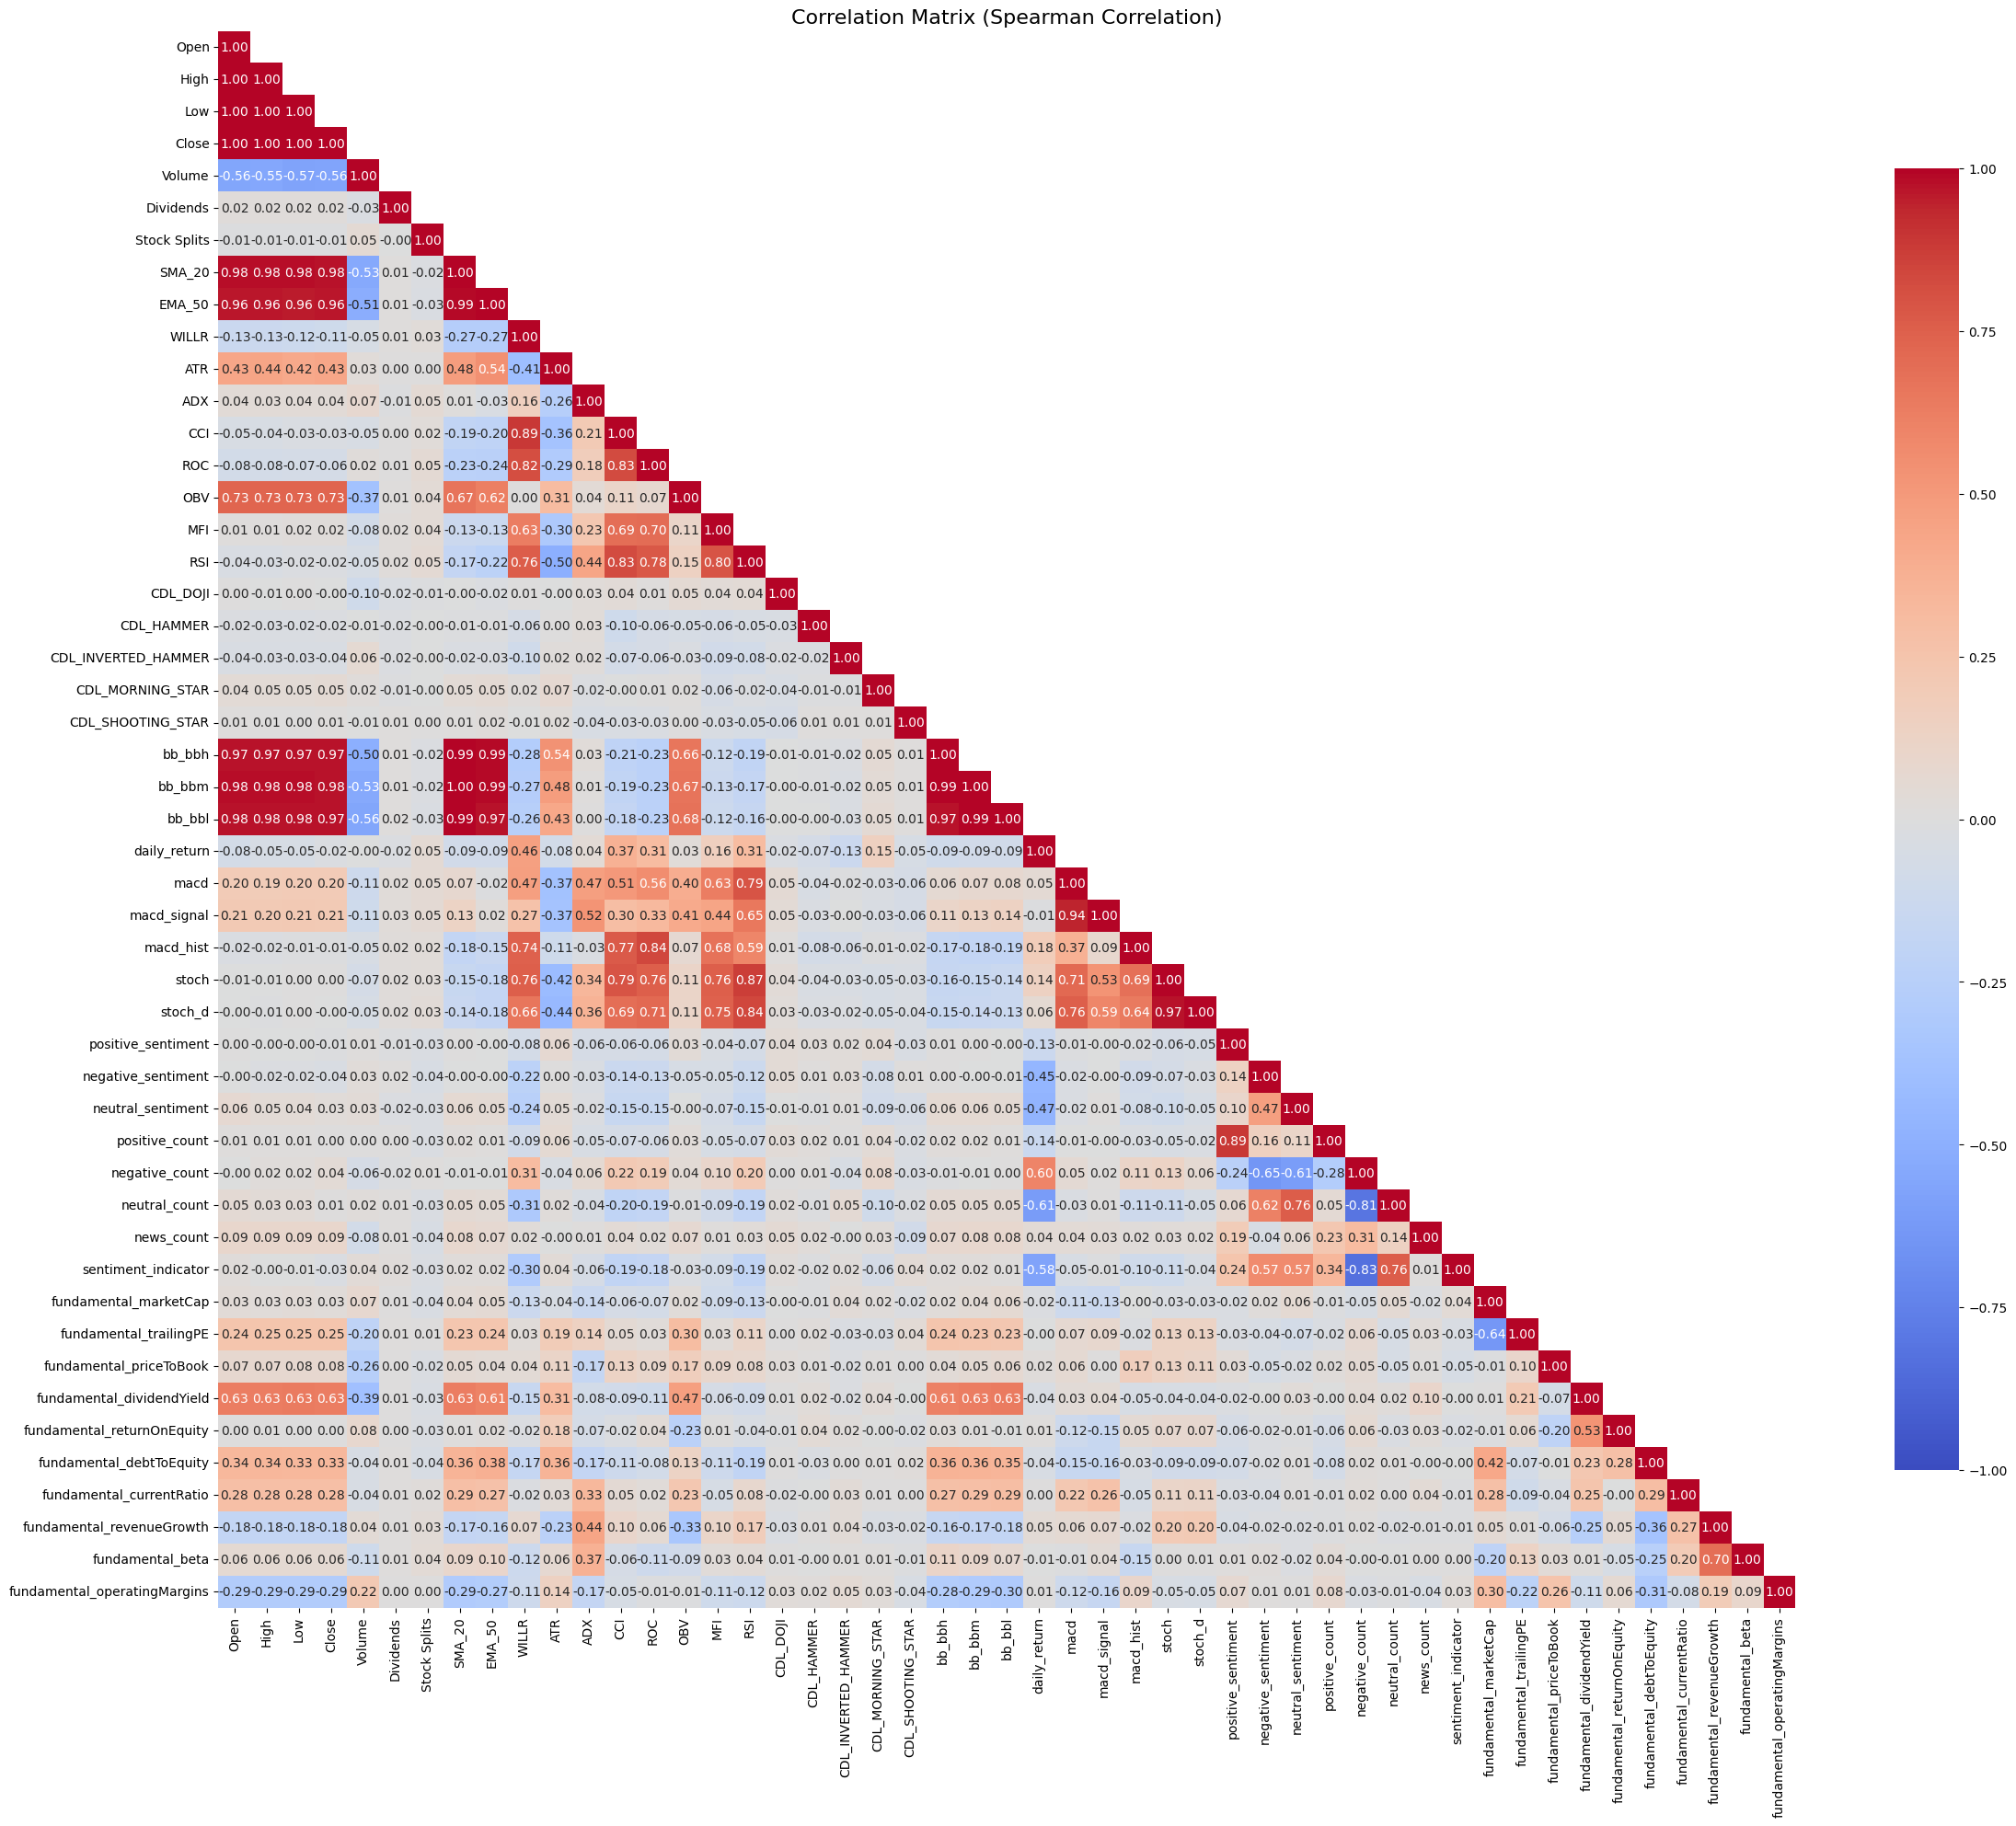

In [37]:
def visualize_correlation_matrix(df, method='spearman', figsize=(24, 20), annot_fontsize=10, rotate_xlabels=90):
    """
    Generate a correlation matrix for numeric columns in the combined DataFrame with improved visibility.
    
    Parameters:
    final_df (pandas.DataFrame): The combined DataFrame
    method (str): Correlation method ('pearson', 'kendall', 'spearman')
    plot (bool): Whether to plot the correlation matrix heatmap
    figsize (tuple): Figure size for the plot
    annot_fontsize (int): Font size for annotation numbers
    rotate_xlabels (int): Degree of rotation for x-axis labels
    
    Returns:
    pandas.DataFrame: Correlation matrix
    """
    numeric_df = df.select_dtypes(include=[np.number])
    corr_matrix = numeric_df.corr(method=method)
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                vmin=-1, vmax=1, center=0, square=True, 
                cbar_kws={"shrink": .8}, annot_kws={"size": annot_fontsize},
                ax=ax)
    
    ax.set_title(f'Correlation Matrix ({method.capitalize()} Correlation)', fontsize=16)
    plt.xticks(rotation=rotate_xlabels)
    plt.yticks(rotation=0)
    
    plt.tight_layout()
    plt.show()

corr_matrix = visualize_correlation_matrix(df_train)
corr_matrix

In [38]:
# Vemos las que tienen una correlación superior a 0.8 para tratarlas

def list_high_correlations(final_df, threshold=0.8, method='pearson'):
    """
    Extract and list correlations above a specified threshold.
    
    Parameters:
    final_df (pandas.DataFrame): The combined DataFrame
    threshold (float): Correlation threshold (default 0.8)
    method (str): Correlation method ('pearson', 'kendall', 'spearman')
    
    Returns:
    list: List of tuples containing high correlations
    """
    # Select numeric columns
    numeric_df = final_df.select_dtypes(include=[np.number])
    
    # Compute correlation matrix
    corr_matrix = numeric_df.corr(method=method)
    
    # Extract high correlations
    high_corr = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr.append((corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))
    
    # Sort by absolute correlation value
    high_corr.sort(key=lambda x: abs(x[2]), reverse=True)
    
    return high_corr

high_correlations = list_high_correlations(df_train, threshold=0.8)
high_correlations

[('bb_bbm', 'SMA_20', 1.0),
 ('High', 'Open', 0.9994045016014227),
 ('Close', 'Low', 0.9993093884689804),
 ('Low', 'Open', 0.9992881514047479),
 ('Close', 'High', 0.9992751815899833),
 ('Low', 'High', 0.9991534322851657),
 ('Close', 'Open', 0.9984765810479015),
 ('bb_bbh', 'SMA_20', 0.9970422636964166),
 ('bb_bbm', 'bb_bbh', 0.9970422636964165),
 ('bb_bbl', 'SMA_20', 0.9964770592232906),
 ('bb_bbl', 'bb_bbm', 0.9964770592232906),
 ('fundamental_beta', 'fundamental_revenueGrowth', 0.9889347995186414),
 ('bb_bbl', 'bb_bbh', 0.9870842194808239),
 ('fundamental_debtToEquity', 'fundamental_marketCap', 0.9842004049723421),
 ('fundamental_returnOnEquity',
  'fundamental_dividendYield',
  0.9838122692545423),
 ('fundamental_operatingMargins', 'fundamental_marketCap', 0.981916803978007),
 ('fundamental_currentRatio', 'fundamental_marketCap', 0.9814030204408511),
 ('fundamental_operatingMargins',
  'fundamental_returnOnEquity',
  0.9811503856007333),
 ('fundamental_currentRatio', 'fundamental_de

In [39]:
# Empezamos quitando algunas columnas no necesarias como:
# - Los sentimientos y el conteo de noticias, que se recogen en un único indicador de sentimiento y de conteo
# - Los dividentos y Stock Splits por ser ceros

columns_to_drop = ['positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'positive_count', 'negative_count', 'neutral_count', 'Dividends', 'Stock Splits']

df_train = df_train.drop(columns_to_drop, axis=1)
df_train.tail()

,Open,High,Low,Close,Volume,SMA_20,EMA_50,WILLR,ATR,ADX,...,fundamental_marketCap,fundamental_trailingPE,fundamental_priceToBook,fundamental_dividendYield,fundamental_returnOnEquity,fundamental_debtToEquity,fundamental_currentRatio,fundamental_revenueGrowth,fundamental_beta,fundamental_operatingMargins
1001,176.238180,176.606291,172.596809,173.114166,66062900,184.849985,182.679995,-97.737605,3.146756,39.886981,...,3.478446e+12,35.461451,50.259842,0.00435,1.530918,153.743734,0.991101,0.050206,1.30419,0.287474
1002,171.422816,174.208564,171.084551,173.601669,61114200,183.994804,182.323983,-89.675446,3.145132,40.659744,...,3.478446e+12,35.461451,50.259842,0.00435,1.530918,153.743734,0.991101,0.050206,1.30419,0.287474
1003,174.178710,175.233311,172.855479,174.944778,46311900,183.166537,182.034602,-83.098756,3.090324,40.817836,...,3.478446e+12,35.461451,50.259842,0.00435,1.530918,153.743734,0.991101,0.050206,1.30419,0.287474
1004,176.158565,176.775404,175.352691,176.327698,42084200,182.364198,181.810802,-73.847018,3.000346,40.171846,...,3.478446e+12,35.461451,50.259842,0.00435,1.530918,153.743734,0.991101,0.050206,1.30419,0.287474
1005,177.611152,180.625725,177.422117,180.197906,52722800,181.711652,181.747551,-39.606981,3.093037,37.945611,...,3.478446e+12,35.461451,50.259842,0.00435,1.530918,153.743734,0.991101,0.050206,1.30419,0.287474


In [ ]:
# Establecemos condiciones de compra

condition_low = [
    (df_train['CDL_ENGULFING'] == 100) & (df_train['Low'] < df_train['bb_bbl'])
    
]

choices_low = [1]
df_train['low_engulfing'] = np.select(conditions, choices, default=0)

In [40]:
numeric_cols = df_train.select_dtypes(include=['float64', 'int64']).columns

def find_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))
    return outliers

outliers_summary = {}
for col in numeric_cols:
    outliers = find_outliers_iqr(df_train[col])
    outliers_summary[col] = outliers.sum()

outliers_summary = pd.DataFrame.from_dict(outliers_summary, orient='index', columns=['Número de outliers según IQR'])
outliers_summary = outliers_summary.sort_values(by='Número de outliers según IQR', ascending=False)
print(outliers_summary)

                              Número de outliers según IQR
CDL_DOJI                                               129
OBV                                                    119
Volume                                                  60
EMA_50                                                  49
daily_return                                            39
fundamental_operatingMargins                            24
fundamental_priceToBook                                 24
fundamental_marketCap                                   24
fundamental_trailingPE                                  24
fundamental_dividendYield                               24
fundamental_returnOnEquity                              24
fundamental_debtToEquity                                24
fundamental_currentRatio                                24
fundamental_revenueGrowth                               24
fundamental_beta                                        24
macd_hist                                               

In [41]:
# Aplicamos lo mismo a test

In [42]:
df_test = pd.read_csv('./test.csv', sep=';', decimal='.')

columns_to_drop = ['positive_sentiment', 'negative_sentiment', 'neutral_sentiment', 'positive_count', 'negative_count', 'neutral_count', 'Dividends', 'Stock Splits']

df_test = df_test.drop(columns_to_drop, axis=1)
df_test.tail()

,Open,High,Low,Close,Volume,SMA_20,EMA_50,WILLR,ATR,ADX,...,fundamental_marketCap,fundamental_trailingPE,fundamental_priceToBook,fundamental_dividendYield,fundamental_returnOnEquity,fundamental_debtToEquity,fundamental_currentRatio,fundamental_revenueGrowth,fundamental_beta,fundamental_operatingMargins
247,225.720001,225.990005,223.039993,225.889999,40687800,218.294217,214.508291,-3.026739,5.533117,20.507912,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417
248,225.770004,227.169998,225.449997,226.509995,30299000,218.382224,214.978946,-2.102150,5.260752,19.410409,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417
249,226.520004,227.979996,225.050003,226.399994,34765500,218.787858,215.426830,-4.905833,5.094269,18.555633,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417
250,227.789993,228.339996,223.899994,224.529999,43695300,219.152430,215.783817,-11.699096,5.047535,17.487487,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417
251,225.660004,228.220001,224.330002,226.839996,38629400,219.609029,216.217393,-5.454057,4.964854,16.495636,...,3.387971e+12,33.255706,51.189308,0.004566,1.565506,159.384755,0.926367,0.048389,1.27404,0.28417


## Modelo LSTM

In [43]:
X_train, y_train = df_train.drop('Close', axis=1), df_train['Close']
X_test, y_test = df_test.drop('Close', axis=1), df_test['Close']

# Scale the features
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def train_model_with_tscv(X, y, model, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=50, batch_size=32, verbose=0)
        
        val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, val_pred)
        scores.append(mse)
    
    return model, scores

# Reshape data for LSTM [samples, time steps, features]
X_train_reshaped = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_reshaped = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Create and train model
model = create_lstm_model((X_train_reshaped.shape[1], X_train_reshaped.shape[2]))
model, scores = train_model_with_tscv(X_train_reshaped, y_train.values.reshape(-1, 1), model)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {np.mean(scores)}")

# Make predictions
predictions = model.predict(X_test_reshaped)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test Set Mean Squared Error: {mse}")
print(f"Test Set Mean Absolute Error: {mae}")
print(f"Test Set R-squared Score: {r2}")

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Cross-validation scores: [6462.672411668148, 6232.125591092978, 5997.991244146627, 946.5253791556349, 701.787516820029]
Mean cross-validation score: 4068.2204285766834
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 851us/step
Test Set Mean Squared Error: 2209.032741511514
Test Set Mean Absolute Error: 43.545562865242125
Test Set R-squared Score: -6.014098618046386


## Modelo Random Forest

In [45]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

def train_model_with_tscv(X, y, model, n_splits=5):
    tscv = TimeSeriesSplit(n_splits=n_splits)
    scores = []
    
    for train_index, val_index in tscv.split(X):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        
        model.fit(X_train, y_train)
        
        val_pred = model.predict(X_val)
        mse = mean_squared_error(y_val, val_pred)
        scores.append(mse)
    
    return model, scores

# Create and train model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model, scores = train_model_with_tscv(X_train_scaled, y_train, model)
print(f"Cross-validation scores: {scores}")
print(f"Mean cross-validation score: {np.mean(scores)}")

# Make predictions
predictions = model.predict(X_test_scaled)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"Test Set Mean Squared Error: {mse}")
print(f"Test Set Mean Absolute Error: {mae}")
print(f"Test Set R-squared Score: {r2}")

Cross-validation scores: [884.7307018082377, 76.96234714366156, 281.54436331684786, 3.0559363852256753, 40.260631842495016]
Mean cross-validation score: 257.31079609929355
Test Set Mean Squared Error: 467.32502544590267
Test Set Mean Absolute Error: 14.443577156066892
Test Set R-squared Score: -0.483845736444696
